In [1]:
# Pseudocode using Pytorch :
# 1. Import the necessary libraries
# 2. Load the image from the folder
# 3. Data preprocessing using various data augmentation pipeline and Image generator.
# 4. Split the train data with validation data.
# 4. Analysis of data such as no of images in each class and no of classes
# 5.Define Forward and Backprop functions
# 6. Build the CNN model
# 7. Perform the training with the hyperparameters like epoch size, batch size, learning rate , with defined loss function and metrics
# 8. Plot the loss and accuracy curves
# 9. Use the test data and estimate the confidence score.


In [2]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage
from skimage import io,transform
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets,models,transforms
from PIL import Image


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#load data
batch_size=20
data_dir = "/content/drive/MyDrive/Projects/Pet classification using CNN/1577957291_deeplearningwithkerasandtensorflow/data"
TEST = 'test'
TRAIN = 'train'
VALID = 'val'

In [5]:
#Data preprocessing
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
image_datasets={x: datasets.ImageFolder(os.path.join(data_dir,x),transform=transform) for x in [TRAIN, TEST]}
num_validation = int(np.floor(0.2* len(image_datasets[TRAIN])))
num_train= len(image_datasets[TRAIN]) - num_validation
#Split the data
train_ds,val_ds=torch.utils.data.random_split(image_datasets[TRAIN],[num_train,num_validation])
test_ds=torch.utils.data.DataLoader(image_datasets[TEST])

# num_train = len(train_data)
# indices = list(range(num_train))
# np.random.shuffle(indices)
# split = int(np.floor(valid_size * num_train))
# train_idx, valid_idx = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

In [8]:

dataloaders = {TRAIN: torch.utils.data.DataLoader(train_ds,batch_size=batch_size,shuffle=True),
               TEST: torch.utils.data.DataLoader(image_datasets[TEST],batch_size,shuffle=True),
               VALID:torch.utils.data.DataLoader(val_ds,batch_size=batch_size,shuffle=True)}


In [9]:
len(dataloaders[TRAIN])
len(dataloaders[TEST])


1

In [10]:
dataset_sizes=len(image_datasets[TRAIN])
class_names=image_datasets[TRAIN].classes
num_classes=len(class_names)
print(class_names)


['cats', 'dogs']


torch.Size([20, 3, 256, 256]) torch.Size([20])


torch.Size([12, 3, 256, 256]) torch.Size([12])


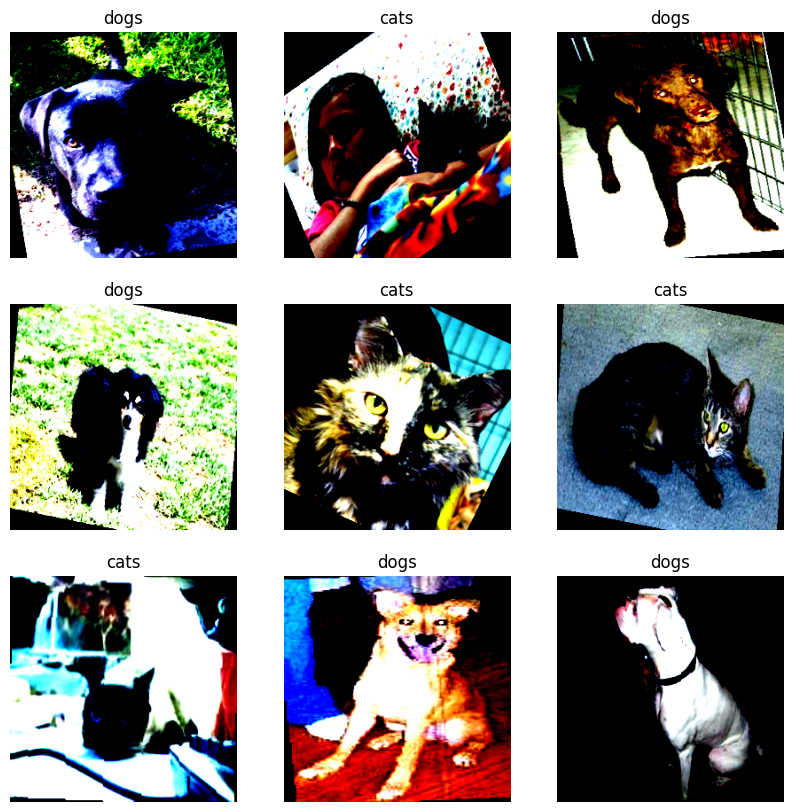

In [11]:
#Visualize the data
#Plot sample images for all the classes
plt.figure(figsize=(10,10))
for images,labels in dataloaders[TRAIN]:
  print(images.shape,labels.shape)
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().transpose(1,2,0))
    plt.title(class_names[labels[i]])
    plt.axis("off")

torch.Size([20, 3, 256, 256]) tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1])


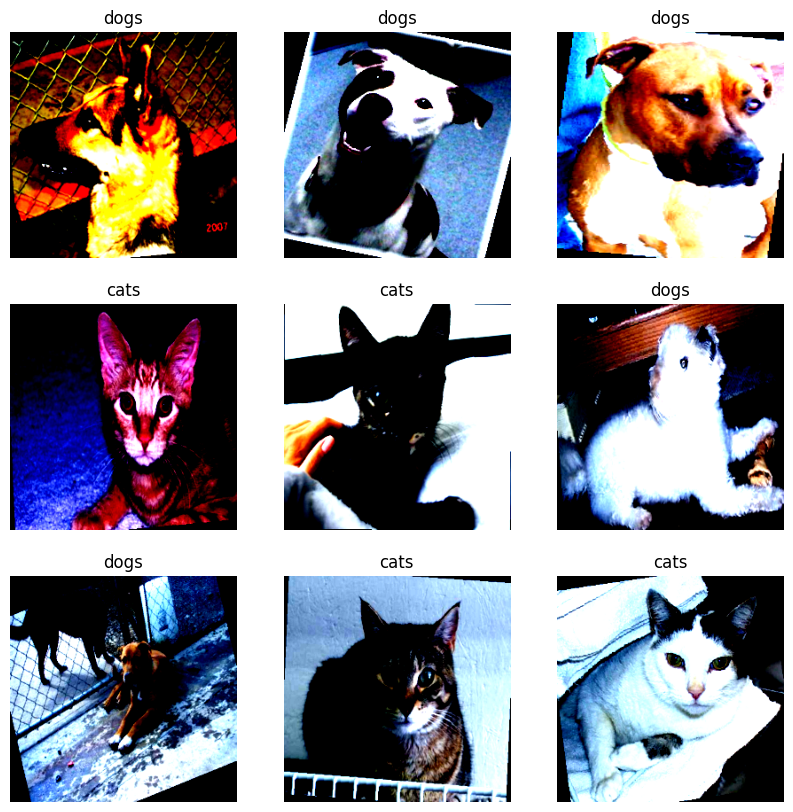

In [12]:
#Visualize the test data
#Plot sample images for all the classes
plt.figure(figsize=(10,10))
for images,labels in dataloaders[TEST]:
  print(images.shape,labels)
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().transpose(1,2,0))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
class PetNN(nn.Module):
  def __init__(self, num_classes, fc_size=20, dropout_prob=0.4):
    super(PetNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64 , kernel_size=5),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )


    self.fc1 = nn.Linear(in_features=64 * 61 * 61, out_features=fc_size)
    #self.bn1 = nn.BatchNorm2d(fc_size)
    self.dropout = nn.Dropout(p=dropout_prob)
    self.fc2 = nn.Linear(in_features=fc_size, out_features=num_classes)

  def forward(self,x):
    out=self.layer1(x)
    out=self.layer2(out)
    out=out.view(out.size(0),-1) #flatten to 2D tensor (batch_size, num_channels * height * width)
    out=torch.relu(self.fc1(out))
    #out=self.bn1(out)
    out=self.dropout(out)
    out=torch.softmax(self.fc2(out),dim=1)
    return(out)

In [14]:
#define hyperparamters, loss function and optimiser
model=PetNN(num_classes)
model.to(device)
error=nn.CrossEntropyLoss()
learning_rate=0.01
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
print(model)

PetNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=238144, out_features=20, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)


In [15]:
#Initialisation of training variables
epochs = 300
count=0
train_accuracy_list = []  # Store train accuracy values
train_loss_list = []      # Store train loss values
valid_accuracy_list = []  # Store validation accuracy values
valid_loss_list = []      # Store validation loss values
test_accuracy_list = []   # Store test accuracy values
labels_list=[]
prediction_list=[]
#iteration_list=list(range(epochs))
iteration_list=[]
#print(iteration_list)
#Training


for epoch in range(epochs):
  for images,labels in dataloaders[TRAIN]:
    images,labels=images.to(device),labels.to(device)
    train_outputs=model(images)
    #print(outputs.shape)
    loss=error(train_outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1
    iteration_list.append(count)


  with torch.no_grad():
    #train_outputs=model(images)
    train_predictions=torch.max(train_outputs,1)[1]
    train_correct=(train_predictions==labels).sum().item()
    train_total=len(labels)
    train_accuracy=train_correct*100/train_total
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(loss.item())

    total=0
    correct=0
  for images,labels in dataloaders[VALID]:
    images,labels=images.to(device),labels.to(device)
    labels_list.append(labels)
    outputs=model(images)
    loss=error(outputs,labels)
    predictions=torch.max(outputs,1)[1].to(device)
    prediction_list.append(predictions)
    correct += (predictions==labels).sum()
    total+=len(labels)
  with torch.no_grad():
    valid_correct = (predictions == labels).sum().item()
    valid_total = len(labels)
    valid_accuracy = valid_correct * 100 / valid_total
    valid_accuracy_list.append(valid_accuracy)
      # accuracy_list.append(accuracy)
      # loss_list.append(loss.data)pend(valid_accuracy)
    valid_loss_list.append(loss.item())

      # accuracy=correct*100/total
      # iteration_list.append(count)

  print("epochs:{},loss:{},train_accuracy:{}%".format(epoch,loss.data,train_accuracy))
  print("epochs:{},loss:{},valid_accuracy:{}%".format(epoch,loss.data,valid_accuracy))
#print(len(train_accuracy_list))

epochs:0,loss:0.938261866569519,train_accuracy:50.0%
epochs:0,loss:0.938261866569519,valid_accuracy:37.5%
epochs:1,loss:0.8132617473602295,train_accuracy:25.0%
epochs:1,loss:0.8132617473602295,valid_accuracy:50.0%
epochs:2,loss:0.938261866569519,train_accuracy:66.66666666666667%
epochs:2,loss:0.938261866569519,valid_accuracy:37.5%
epochs:3,loss:0.938261866569519,train_accuracy:41.666666666666664%
epochs:3,loss:0.938261866569519,valid_accuracy:37.5%
epochs:4,loss:0.938261866569519,train_accuracy:50.0%
epochs:4,loss:0.938261866569519,valid_accuracy:37.5%
epochs:5,loss:0.938261866569519,train_accuracy:33.333333333333336%
epochs:5,loss:0.938261866569519,valid_accuracy:37.5%
epochs:6,loss:0.938261866569519,train_accuracy:66.66666666666667%
epochs:6,loss:0.938261866569519,valid_accuracy:37.5%
epochs:7,loss:0.938261866569519,train_accuracy:50.0%
epochs:7,loss:0.938261866569519,valid_accuracy:37.5%
epochs:8,loss:0.9382617473602295,train_accuracy:50.0%
epochs:8,loss:0.9382617473602295,valid_acc

In [16]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Projects/Pet classification using CNN/1577957291_deeplearningwithkerasandtensorflow/data/PetNN.pt')


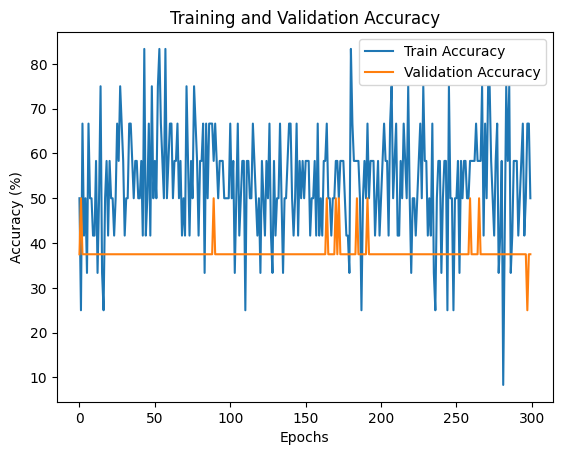

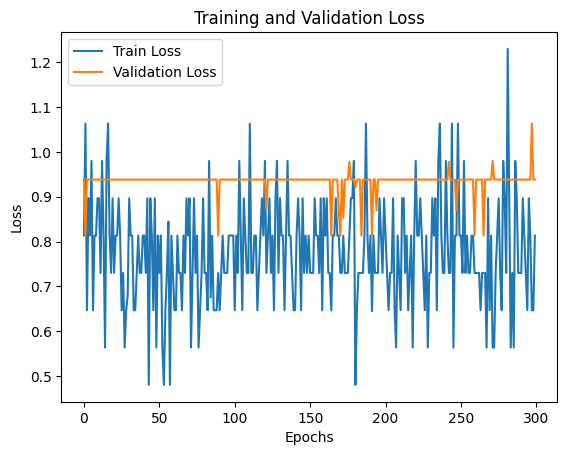

In [17]:
# Plotting train and validation accuracy/loss together

plt.plot(list(range(epochs)), train_accuracy_list, label='Train Accuracy')
plt.plot(list(range(epochs)), valid_accuracy_list, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

plt.plot(list(range(epochs)), train_loss_list, label='Train Loss')
plt.plot(list(range(epochs)), valid_loss_list, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# # Plotting test accuracy in a separate plot
# plt.plot(iteration_list[4::5], test_accuracy_list, label='Test Accuracy', color='r')
# plt.xlabel("No. of Iteration")
# plt.ylabel("Accuracy (%)")
# plt.title("Test Accuracy")
# plt.legend()
# plt.show()

In [18]:
test_path='/content/drive/MyDrive/Projects/Pet classification using CNN/1577957291_deeplearningwithkerasandtensorflow/data/test'
print(os.listdir(test_path))

['cats', 'dogs']


In [19]:
# #test the model
# model = PetNN(2).to(device)
# model.load_state_dict(torch.load('/content/drive/MyDrive/Projects/Pet classification using CNN/1577957291_deeplearningwithkerasandtensorflow/data/PetNN.pt'))
# model.eval()
# test_path='/content/drive/MyDrive/Projects/Pet classification using CNN/1577957291_deeplearningwithkerasandtensorflow/data/test'
# for class_name in os.listdir(test_path):
#   print(f"Class name: {class_name}")
#   class_path=os.path.join(test_path,class_name)
#   for image_name in os.listdir(class_path):
#     image_path=os.path.join(class_path,image_name)
#     image=Image.open(image_path)
#     # Define a transformation to convert PIL Image to PyTorch tensor
#     transform = transforms.ToTensor()

#     # Apply the transformation to the image
#     transform = transforms.Compose([
#     transforms.RandomRotation(30),
#     transforms.Resize((256, 256)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         ])
#     image_tensor = transform(image)
#     image_tensor=image_tensor.unsqueeze(0)
#     image_tensor=image_tensor.to(device)
#     #print(image_tensor.shape)

#     with torch.no_grad():
#       outputs=model(image_tensor)

#     predicted_class_index=torch.max(outputs,1)[1].to(device)
#     #predicted_class_index=torch.argmax(outputs,dim=1).item()
#     print(predicted_class_index)
#     predicted_class=class_names[predicted_class_index]
#     confidence_scores = torch.softmax(outputs, dim=1)


#     print(f'Image : {image_name}, Predicted class : {predicted_class},confidence scores:{confidence_scores}')












In [22]:

def predict(img_detect, model):
    img = transform(img_detect).unsqueeze(0).cuda()  # Apply transformation and add batch dimension
    model.eval()  # Set eval mode
    output = model(img)
    predicted = torch.argmax(output)
    return predicted

In [23]:
model = PetNN(2)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Projects/Pet classification using CNN/1577957291_deeplearningwithkerasandtensorflow/data/PetNN.pt'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

test_path = '/content/drive/MyDrive/Projects/Pet classification using CNN/1577957291_deeplearningwithkerasandtensorflow/data/test'
for class_name in os.listdir(test_path):
  class_path = os.path.join(test_path, class_name)
  for image_name in os.listdir(class_path):
    image_path = os.path.join(class_path, image_name)
    image = Image.open(image_path)
    predicted_class_index = predict(image, model)
    predicted_class = class_names[predicted_class_index.item()]
    print(f"Image: {image_name}, Predicted class: {predicted_class}")

cuda:0
Image: 110.jpg, Predicted class: dogs
Image: 104.jpg, Predicted class: dogs
Image: 109.jpg, Predicted class: dogs
Image: 101.jpg, Predicted class: dogs
Image: 106.jpg, Predicted class: dogs
Image: 107.jpg, Predicted class: dogs
Image: 105.jpg, Predicted class: dogs
Image: 108.jpg, Predicted class: dogs
Image: 103.jpg, Predicted class: dogs
Image: 102.jpg, Predicted class: dogs
Image: 106.jpg, Predicted class: dogs
Image: 105.jpg, Predicted class: dogs
Image: 103.jpg, Predicted class: dogs
Image: 110.jpg, Predicted class: dogs
Image: 109.jpg, Predicted class: dogs
Image: 101.jpg, Predicted class: dogs
Image: 107.jpg, Predicted class: dogs
Image: 104.jpg, Predicted class: dogs
Image: 102.jpg, Predicted class: dogs
Image: 108.jpg, Predicted class: dogs


In [24]:
# Test loop
test_correct = 0
test_total = 0
test_acc_list=[]
with torch.no_grad():
    for images, labels in dataloaders[TEST]:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
        test_correct += (predictions == labels).sum().item()
        test_total += len(labels)
        test_accuracy = test_correct * 100 / test_total
        print("Test Accuracy: {}%".format(test_accuracy))







Test Accuracy: 50.0%
